In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

# torch library

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [3]:
import torchvision.datasets as datasets

# data direct
data_root = './data'

train_set0 = datasets.MNIST(
    root = data_root,  
    train = True,  
    download = True)

In [4]:
import torchvision.transforms as transforms

# Transforms

transform = transforms.Compose([
    # (1) to tensor
    transforms.ToTensor(),
    
    # (2) normalize
    transforms.Normalize(0.5, 0.5),
    
    # (3) to 1 tensor
    transforms.Lambda(lambda x: x.view(-1)),
])

In [5]:
# Dataset

# train data
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# test data
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

In [6]:
from torch.utils.data import DataLoader

# batch size
batch_size = 100

# train dataloader with shuffle
train_loader = DataLoader(
    train_set, batch_size = batch_size, 
    shuffle = True)

# test dataloader
test_loader = DataLoader(
    test_set,  batch_size = batch_size, 
    shuffle = False)

In [7]:
for images, labels in train_loader:
    break

for i in range(20):
    # numpy
    image = images[i].numpy()
    label = labels[i]
    

In [8]:
# deg of input
n_input = image.shape[0]

# deg of output
# the num of classes
n_output = len(set(list(labels.data.numpy())))

#   # of hidden node
n_hidden = 50

# print hyperparameters
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 50 n_output: 10


In [9]:
# model
# in: 784 out:10 hidden: 1 layer

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # hidden
        self.l1 = nn.Linear(n_input, n_hidden)

        # Sigmoid
        self.sigmoid = nn.Sigmoid()
        
        # output
        self.l2 = nn.Linear(n_hidden, n_output)


   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        return x3

In [10]:
# model instance
net = Net(n_input, n_output, n_hidden).to(device)

# loss function: cross entropy
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.1)

# epoch
num_epochs = 30

# record result
history = np.zeros((0,5))

In [11]:
# loop

for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # training
    for inputs, labels in train_loader:
        n_train += len(labels)

        # device
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # init grad
        optimizer.zero_grad()

        # calc output
        outputs = net(inputs)

        # calc loss
        loss = criterion(outputs, labels)

        # grad backward
        loss.backward()
    
        # modify parameters
        optimizer.step()

        # predict labels
        predicted = torch.max(outputs, 1)[1]

        # calc loss and accuracy
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    # predict
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # calc output
        outputs_test = net(inputs_test)

        # calc loss
        loss_test = criterion(outputs_test, labels_test)

        # output pred
        predicted_test = torch.max(outputs_test, 1)[1]

        # calc loss and accu
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # calc metrics and recode them
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

Epoch [1/30], loss: 0.84968 acc: 0.80643 val_loss: 0.40051, val_acc: 0.89810
Epoch [2/30], loss: 0.35993 acc: 0.90218 val_loss: 0.30266, val_acc: 0.91780
Epoch [3/30], loss: 0.29641 acc: 0.91617 val_loss: 0.26437, val_acc: 0.92560
Epoch [4/30], loss: 0.26182 acc: 0.92510 val_loss: 0.24066, val_acc: 0.93000
Epoch [5/30], loss: 0.23804 acc: 0.93183 val_loss: 0.22701, val_acc: 0.93230
Epoch [6/30], loss: 0.21902 acc: 0.93700 val_loss: 0.20913, val_acc: 0.93940
Epoch [7/30], loss: 0.20376 acc: 0.94155 val_loss: 0.19679, val_acc: 0.94180
Epoch [8/30], loss: 0.19046 acc: 0.94528 val_loss: 0.18880, val_acc: 0.94350
Epoch [9/30], loss: 0.17892 acc: 0.94933 val_loss: 0.17971, val_acc: 0.94780
Epoch [10/30], loss: 0.16986 acc: 0.95110 val_loss: 0.17085, val_acc: 0.94940
Epoch [11/30], loss: 0.16092 acc: 0.95412 val_loss: 0.16202, val_acc: 0.95110
Epoch [12/30], loss: 0.15382 acc: 0.95612 val_loss: 0.15698, val_acc: 0.95300
Epoch [13/30], loss: 0.14735 acc: 0.95882 val_loss: 0.15103, val_acc: 0.9

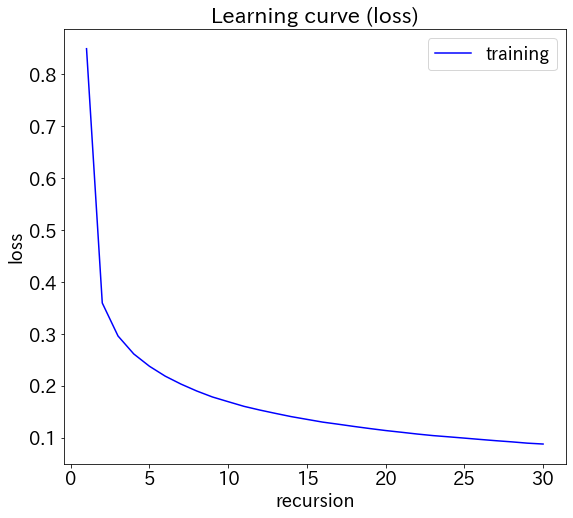

In [12]:
# learning curve
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams["font.size"] = 18
plt.plot(history[:,0], history[:,1], 'b', label='training')
plt.xlabel('recursion')
plt.ylabel('loss')
plt.title('Learning curve (loss)')
plt.legend()
plt.show()

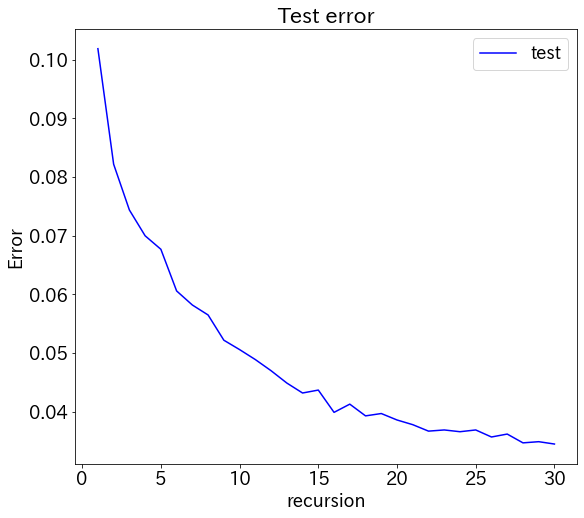

In [13]:
# test error

plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams["font.size"] = 18
plt.plot(history[:,0], 1-history[:,4], 'b', label='test')
plt.xlabel('recursion')
plt.ylabel('Error')
plt.title('Test error')
plt.legend()
plt.show()